In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

import os # accessing directory structure
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
DATASET_PATH = "/media/vidhikatkoria/Research/vr_dataset/"
print(os.listdir(DATASET_PATH))

['rmsprop.png', 'data_small.csv', 'data_sp.csv', 'epoch50.png', 'data.csv', 'dress_dataset', 'adadelta.png', 'epoch10.png', 'epoch10-sgd_mom0.6lr0.01.png', 'data_sep.csv', 'batch-size5.png', 'adam.png', 'dress_dataset_small']


In [6]:
df = pd.read_csv(DATASET_PATH + "data_small.csv")#, nrows=5000, error_bad_lines=False)
df.head(10)
# df.size

,label,image
0,Shirts,15970.jpg
1,Tshirts,53759.jpg
2,Tshirts,1855.jpg
3,Shirts,30805.jpg
4,Shirts,26960.jpg
5,Shirts,12369.jpg
6,Tshirts,7990.jpg
7,Shirts,37812.jpg
8,Tshirts,4729.jpg
9,Shirts,56825.jpg


In [8]:
label = df['label'].tolist()
image_list = df['image'].tolist()

In [9]:
batch_size = 10

In [10]:
from keras_preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    validation_split=0.2
)

training_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "dress_dataset_small/",
    x_col="image",
    y_col="label",
    target_size=(80,80),
    batch_size=batch_size,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "dress_dataset_small/",
#     directory=folder_path,
    x_col="image",
    y_col="label",
    target_size=(80,80),
    batch_size=batch_size,
    subset="validation"
)

classes = len(training_generator.class_indices)

Found 2741 validated image filenames belonging to 4 classes.
Found 685 validated image filenames belonging to 4 classes.


In [11]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn import svm

def create_model():
#     create the base pre-trained model
    base_model = VGG19(input_shape=(80, 80, 3), include_top=False, weights='imagenet')

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)
#     optimizer = SGD(lr=learn_rate, momentum=momentum)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [12]:
from math import ceil

H = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=ceil(0.8 * (df.size / batch_size)),

    validation_data=validation_generator,
    validation_steps=ceil(0.2 * (df.size / batch_size)),
    
    epochs=5,
    verbose=1
)


Epoch 1/5
549/549 [==============================] - 504s 919ms/step - loss: 1.4913 - accuracy: 0.8717 - val_loss: 2.5405 - val_accuracy: 0.7723
Epoch 2/5
549/549 [==============================] - 533s 971ms/step - loss: 0.3461 - accuracy: 0.9415 - val_loss: 0.0252 - val_accuracy: 0.9182
Epoch 3/5
405/549 [=====================>........] - ETA: 1:58 - loss: 0.2028 - accuracy: 0.9643

KeyboardInterrupt: 

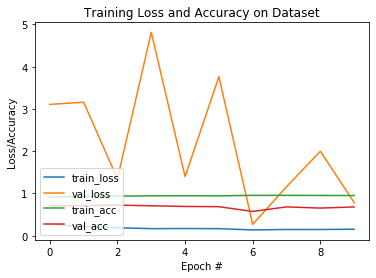

In [185]:
N = 10
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")